# COMP4167 Natural Language Processing
# Practical I - Part II

In this part we will continue the work on the disaster tweet classification. Here we will:

- Apply further explaratory data analysis of text
- Clean the text data using NLTK

The goal of this work is to understand better the data and how to perform explaratory analysis with text data.

### Importing the libraries

- make sure the libraries are already installed using pip or conda
- install the latest version of the libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter

# General science/numeric tools
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# NLTK for NLP tools such as stemming, lemmatizing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import gensim
from tqdm.notebook import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
data_df = pd.read_csv('data/train.csv') # we will only load the train file as the test.csv file does not contain labels

## Explatory data analysis
- manually explore some of the data by looking at random samples of the dataframe
- explore the word counts in the tweets and the punctuations 
- explore biagrams in the text

First lets check the basic contents of the file by looking at the head and tail of the dataframe:

In [7]:
data_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
data_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


And a random sample:

In [9]:
list(data_df.loc[np.random.randint(data_df.shape[0])])

[2040,
 'casualties',
 nan,
 'Civilian Casualties in Afghanistan Reach Record High http://t.co/r8pTVFUh5X http://t.co/npCKK0tlEQ',
 1]

### Most common words
To explore the words we will create a corpus per class:

In [10]:
def create_corpus(data,target):
    corpus = []
    
    # Take the text field per raw in the target class and split the sentences into words to add to the corpus
    for x in data.loc[data['target'] == target, 'text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

<BarContainer object of 10 artists>

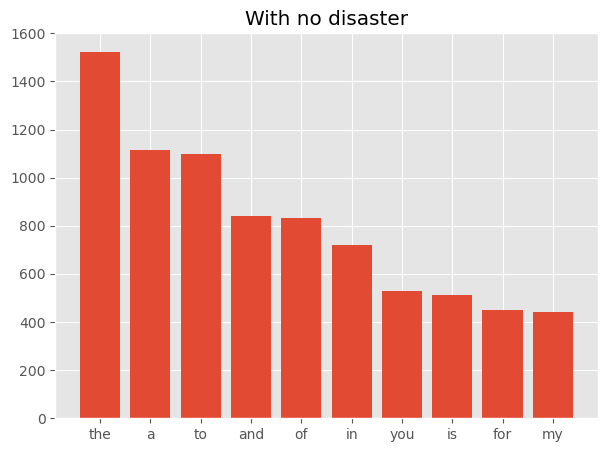

In [7]:
# build the corpus for no disaster class(0)
no_disaster_corpus = create_corpus(data_df, 0)


# build a dictionary to associate each word with its count
no_disaster_dic = defaultdict(int) 


for word in no_disaster_corpus:
    if word in stop:
        no_disaster_dic[word] += 1

# sort the words by their counts 
top_n = 10 # the number of top words to plot
top   = sorted(no_disaster_dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

x, y = zip(*top)
plt.figure(figsize=(7,5))
plt.title('With no disaster')
plt.bar(x, y)

## now we repeat the same analysis for the disaster class(1)

<BarContainer object of 10 artists>

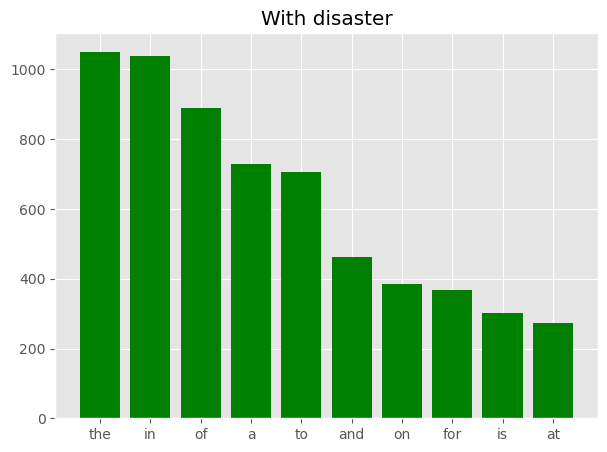

In [8]:
disaster_corpus = create_corpus(data_df,1)

#build a dictionary to associate each word with its count
disaster_dic = defaultdict(int) 

for word in disaster_corpus:
    if word in stop:
        disaster_dic[word] += 1

# sort the words by their counts 
top_n = 10 # the number of top words to plot
top   = sorted(disaster_dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

x, y = zip(*top)
plt.figure(figsize=(7,5))
plt.title('With disaster')
plt.bar(x, y,color='g')

<i>in</i> is almost on the top keyword. During disaster we try to explain where is it, so this is a reasonable outcome.

### Punctuation
Now we will explore the punctuation in both corpora:

In [9]:
special = [char for char in string.punctuation]
special_str= string.punctuation

punc_no_disaster = np.zeros(len(special))

for i in no_disaster_corpus:
    if i in special:
        punc_no_disaster[special_str.find(i)] += 1
        
punc_disaster = np.zeros(len(special))

for i in disaster_corpus:
    if i in special:
        punc_disaster[special_str.find(i)] += 1       

<Axes: >

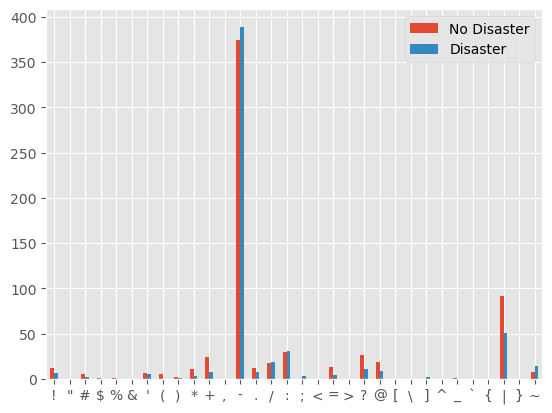

In [10]:
df = pd.DataFrame({'No Disaster': punc_no_disaster,
                   'Disaster': punc_disaster}, index=special)
df.plot.bar(rot=0)

Punctuation is almost the same. Maybe we can delete it.

## Most common words in both corpa after removing the stop words
Use python's `counter` class from the collections library:

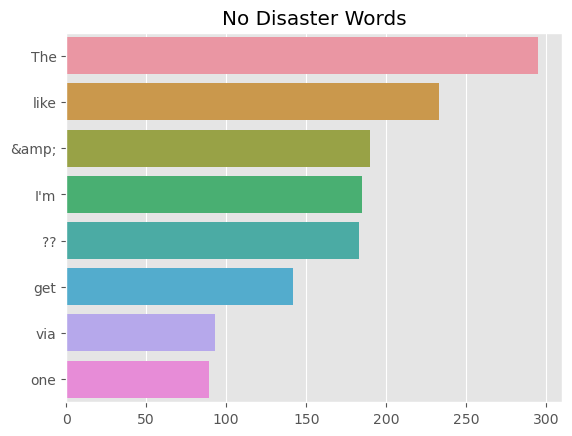

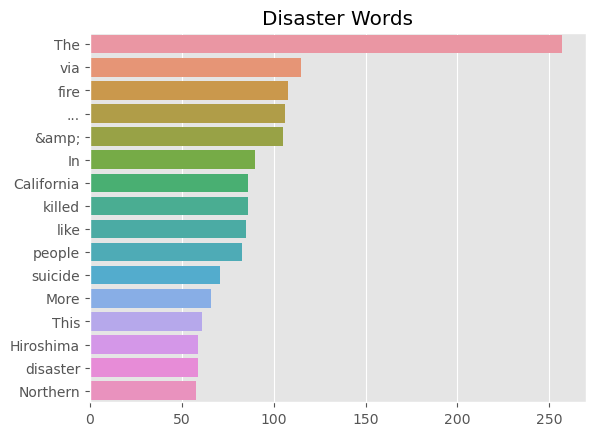

In [42]:
def plot_most_common_words(corpus, title, n_top=40):
    counter = Counter(corpus)
    most_common = counter.most_common()
    x = []
    y = []

    for word, count in most_common[:n_top]:
        if word not in stop and word not in string.punctuation and len(word)>1:
            x.append(word) 
            y.append(count)
        
    sns.barplot(x=y, y=x, orient='h')
    plt.title(title)
    plt.show()
    
plot_most_common_words(no_disaster_corpus,'No Disaster Words', n_top=60)
plot_most_common_words(disaster_corpus,'Disaster Words', n_top=60)

### Bigrams
We will use CountVectorizer to visualize the top bigrams in the tweets.
CounterVectorizer is built from the original text. We will then choose the top n biagrams ordered by their frequency in the tweets

In [15]:
def get_top_tweet_bigrams(corpus, n=10):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # parameter is set for 2 (bigram)


    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

Text(0.5, 1.0, 'Biagrams (all data)')

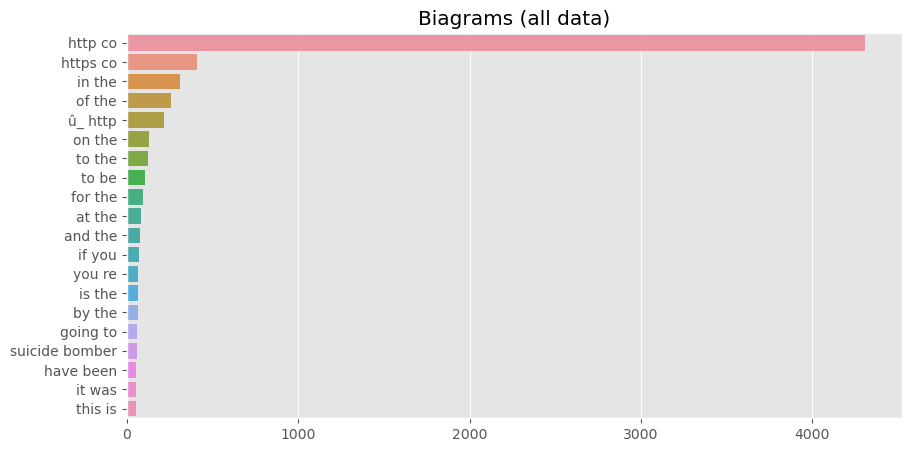

In [16]:
# First let us check the biagrams of the full dataset
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(data_df['text'],n=20)

y, x = map(list, zip(*top_tweet_bigrams))

sns.barplot(x=x, y=y)
plt.title('Biagrams (all data)')

Text(0.5, 1.0, 'Biagrams (disaster data)')

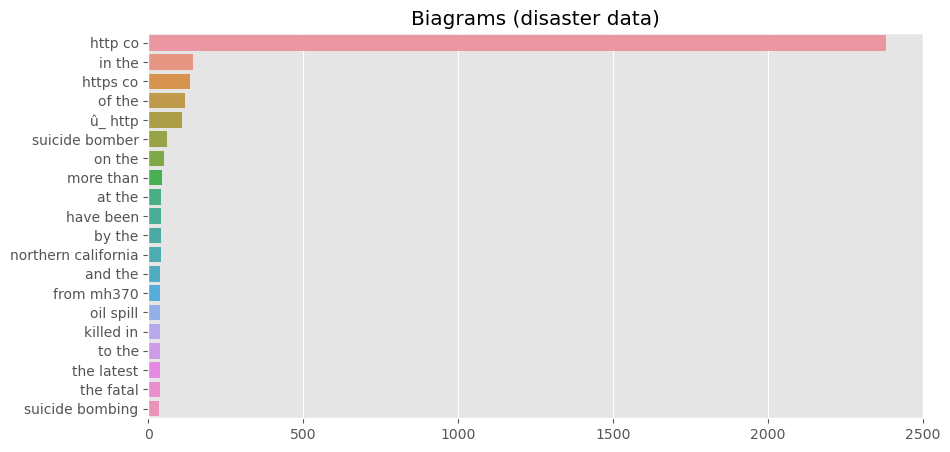

In [17]:
# Now the biagrams of the disaster data
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(data_df['text'][data_df['target']==1],n=20)

y, x = map(list, zip(*top_tweet_bigrams))

sns.barplot(x=x, y=y)
plt.title('Biagrams (disaster data)')

Text(0.5, 1.0, 'Biagrams (no disaster data)')

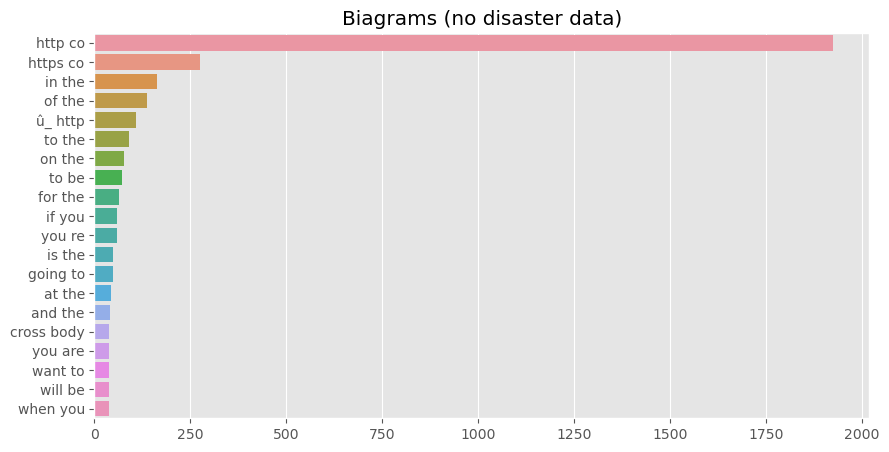

In [18]:
# The biagrams of the no disaster data
plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(data_df['text'][data_df['target']==0],20)

y, x = map(list, zip(*top_tweet_bigrams))

sns.barplot(x=x, y=y)
plt.title('Biagrams (no disaster data)')

## Data Cleaning
From the data exploration it is clear that there is noise due to URL text, like `http`, `https`, `co`, etc. The first step of cleaning the data is to remove the URLs, HTML tags, and emojis. We will use regular expressions to do this task.

We will first define a function that cleans the text and then apply it to all the raw text in the data frame.

In [19]:
def remove_URL(text):
    url = re.compile(r'https?://\S+ | www\.\S+')
    return url.sub('', text)

example = 'New competition launched: https://www.kaggle.com/c/nlp-getting-started'
remove_URL(example)

'New competition launched: '

In [20]:
data_df['text'] = data_df['text'].apply(lambda x: remove_URL(x))

In [23]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)


example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""
print(remove_html(example))
print(example)


Real or Fake
Kaggle 
getting started

<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>


In [24]:
data_df['text'] = data_df['text'].apply(lambda x: remove_html(x))

In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [26]:
data_df['text'] = data_df['text'].apply(lambda x: remove_emoji(x))

In [27]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


example = "I am #king"
print(remove_punct(example))

I am king


In [28]:
data_df['text'] = data_df['text'].apply(lambda x: remove_punct(x))

## Lemmatization

Next step is to lemmatize the strings using the `nltk` library. Other useful library to use Spacy.

In [32]:
#還原詞型，過去式未來式 Ved Ving 
#同功用的還有stemming，但 amused, amusing裡面ste會切成amus, lem會轉成amuse
#但stemming比較快
#nltk是用來處理文字的package, 通常用在英文上

#keywords = data_df.keyword.unique()[1:]
#keywords = list(map(lambda x: x.replace('%20', ' '), keywords))

wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    sentence_words = sentence.split(' ')
    new_sentence_words = list()
    
    for sentence_word in sentence_words:
        sentence_word = sentence_word.replace('#', '')
        new_sentence_word = wnl.lemmatize(sentence_word.lower(), wordnet.VERB)
        new_sentence_words.append(new_sentence_word)
        
    new_sentence = ' '.join(new_sentence_words)
    new_sentence = new_sentence.strip()
    
    return new_sentence

In [30]:
data_df['text'] = data_df['text'].apply(lambda x: lemmatize_sentence(x))

## Review random samples of the text after cleaning

In [43]:
# select a random sample
list(data_df.loc[np.random.randint(data_df.shape[0])])

[3396,
 'demolition',
 'Buffalo, NY',
 'up house save from demolition   will be move to orcas island washington',
 0]

Now rerun the bigram plots above. They should be much more useful now the data has been cleaned.